In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
burglary_df  = pd.read_csv("data/residential_burglary.csv", parse_dates=["Month"])

# Combine 'Year' and 'Month' into a single datetime column
burglary_df ["Month"] = pd.to_datetime(burglary_df ["Year"].astype(str) + "-" + burglary_df ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary_df.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

# Load IMD data
imd_df = pd.read_excel("data/imd2019_wards.xlsx", usecols=["Ward Code", "IMD average score"])
imd_df = imd_df.rename(columns={"IMD average score": "IMD"})

# Merge burglary data with IMD scores
data = pd.merge(burglary_monthly, imd_df, on="Ward Code", how="left")

# Clean data
data = data.dropna(subset=["IMD"])  # Remove wards without IMD data
print(f"Working with {data['Ward Code'].nunique()} wards with complete data")

C:\Users\gusta\AppData\Local\Temp\ipykernel_9168\388101945.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  burglary_df  = pd.read_csv('data/residential_burglary.csv', parse_dates=['Month'])


Working with 149 wards with complete data


In [21]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

def forecast_ward(ward_df, test_months=12):
    """Forecast for a single ward with automatic SARIMA tuning"""
    train = ward_df.iloc[:-test_months]
    test = ward_df.iloc[-test_months:]

    # Auto-tune SARIMA parameters
    model = auto_arima(train["Count"], seasonal=True, m=12,
                      suppress_warnings=True, stepwise=True)

    # Fit best model
    sarima = SARIMAX(train["Count"],
                    order=model.order,
                    seasonal_order=model.seasonal_order)
    results = sarima.fit(disp=False)

    # Generate predictions
    forecast = results.get_forecast(steps=test_months)
    preds = forecast.predicted_mean
    ci = forecast.conf_int()

    # Calculate residuals and signs
    train_pred = results.get_prediction()
    residuals = train["Count"] - train_pred.predicted_mean
    residual_signs = np.sign(residuals)

    return {
        "ward_code": ward_df["Ward Code"].iloc[0],
        "imd": ward_df["IMD"].iloc[0],
        "train_data": train,
        "test_data": test,
        "sarima_pred": preds,
        "residuals": residuals,
        "residual_signs": residual_signs,
        "model": results,
        "confidence_interval": ci
    }

# # Process all wards
all_wards_data = []
for ward_code, group in data.groupby("Ward Code"):
    if len(group) >= 18:  # Minimum 1.5 years of data
        all_wards_data.append(forecast_ward(group.reset_index(drop=True)))

# all_wards_code = []
#
# for ward_code, group in data.groupby('Ward Code'):
#     all_wards_data.append(group.reset_index(drop=True))
#     all_wards_code.append(ward_code)
#
# print(all_wards_data[1])
# print(all_wards_code[0])

F:\Work\UniProject\MD_CBL\MD_CBL-Group_2\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
F:\Work\UniProject\MD_CBL\MD_CBL-Group_2\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
F:\Work\UniProject\MD_CBL\MD_CBL-Group_2\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
F:\Work\UniProject\MD_CBL\MD_CBL-Group_2\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as start

In [24]:
# Prepare residual dataset
residual_records = []
for ward_data in all_wards_data:
    avg_residual = np.abs(ward_data["residuals"]).mean()
    residual_records.append({
        "IMD": ward_data["imd"],
        "avg_residual": avg_residual,
        "residual_sign": ward_data["residual_signs"].mean()
    })
residual_df = pd.DataFrame(residual_records)

# Train XGBoost residual model
X = residual_df[["IMD"]]
y = residual_df["avg_residual"]
residual_model = xgb.XGBRegressor(objective="reg:squarederror")
residual_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Generate hybrid predictions
results = []
for ward_data in all_wards_data:
    # Get base SARIMA predictions
    sarima_pred = ward_data["sarima_pred"]

    # Get residual adjustment
    imd_value = np.array([[ward_data["imd"]]])
    residual_adj = residual_model.predict(imd_value)[0]

    # Apply sign-aware adjustment
    sign = np.sign(ward_data["residual_signs"].mean())
    hybrid_pred = sarima_pred + (sign * residual_adj)

    # Store results
    results.append({
        "ward_code": ward_data["ward_code"],
        "actual": ward_data["test_data"]["Count"].values,
        "sarima_pred": sarima_pred.values,
        "hybrid_pred": hybrid_pred.values
    })

Overall Performance:
SARIMA MAE: 3.21
Hybrid MAE: 3.33
SARIMA RMSE: 3.83
Hybrid RMSE: 4.00


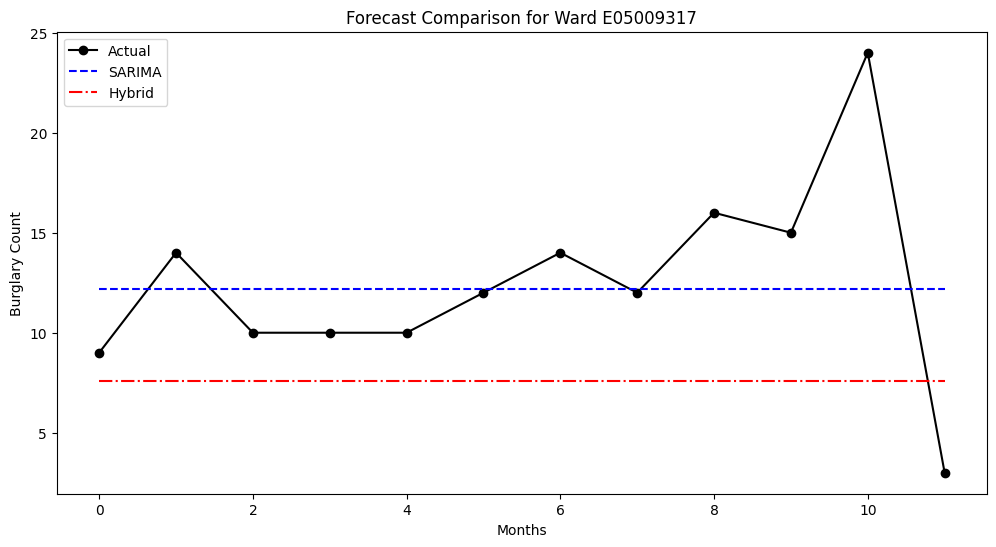

In [29]:
# Calculate metrics
metrics = []
for res in results:
    metrics.append({
        "ward": res["ward_code"],
        "sarima_mae": mean_absolute_error(res["actual"], res["sarima_pred"]),
        "hybrid_mae": mean_absolute_error(res["actual"], res["hybrid_pred"]),
        "sarima_rmse": np.sqrt(mean_squared_error(res["actual"], res["sarima_pred"])),
        "hybrid_rmse": np.sqrt(mean_squared_error(res["actual"], res["hybrid_pred"]))
    })
metrics_df = pd.DataFrame(metrics)

print("Overall Performance:")
print(f"SARIMA MAE: {metrics_df['sarima_mae'].mean():.2f}")
print(f"Hybrid MAE: {metrics_df['hybrid_mae'].mean():.2f}")
print(f"SARIMA RMSE: {metrics_df['sarima_rmse'].mean():.2f}")
print(f"Hybrid RMSE: {metrics_df['hybrid_rmse'].mean():.2f}")

# Visualize sample ward predictions
sample_ward = results[0]
months = np.arange(len(sample_ward["actual"]))

plt.figure(figsize=(12,6))
plt.plot(months, sample_ward["actual"], "ko-", label="Actual")
plt.plot(months, sample_ward["sarima_pred"], "b--", label="SARIMA")
plt.plot(months, sample_ward["hybrid_pred"], "r-.", label="Hybrid")
plt.title(f"Forecast Comparison for Ward {sample_ward['ward_code']}")
plt.xlabel("Months")
plt.ylabel("Burglary Count")
plt.legend()
plt.show()